In [1]:
# !pip install pyqg-jax
# !pip install cmocean

In [4]:
!pip install jax

In [2]:
# Set environment variable for double precision support
import os
os.environ['JAX_ENABLE_X64'] = 'True'
import operator
import functools
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import jax
import jax.numpy as jnp
import pyqg_jax


jax.config.update('jax_enable_x64', True)

base_model = pyqg_jax.qg_model.QGModel(
    nx=64,
    ny=64,
    precision=pyqg_jax.state.Precision.DOUBLE,
)

param_model = pyqg_jax.parameterizations.smagorinsky.apply_parameterization(
    base_model, constant=0.08,
)

stepper = pyqg_jax.steppers.AB3Stepper(dt=14400.0)
stepped_model = pyqg_jax.steppers.SteppedModel(
    param_model, stepper
)



In [1]:
init_state = stepped_model.create_initial_state(jax.random.key(0))

# Extract the initial q and flatten it to create x0
q_init = init_state.state.model_state.q
x0 = q_init.reshape(-1)
n = x0.shape[0]

H = jnp.eye(n)


# Process noise covariance Q
Q = jnp.eye(n) * 1e-5  # Adjust as needed

# Observation noise covariance R
R = jnp.eye(n) * 1e-2  # Adjust as needed

# @functools.partial(jax.jit, static_argnames=["num_steps"])
# def roll_out_state(state, num_steps):
#     def loop_fn(carry, _x):
#         current_state = carry
#         next_state = stepped_model.step_model(current_state)
#         return next_state, current_state

#     _final_carry, traj_steps = jax.lax.scan(
#         loop_fn, state, None, length=num_steps
#     )
#     return traj_steps
def roll_out_state(state, num_steps, key):
    def loop_fn(carry, key):
        current_state = carry
        # Step the model forward (without process noise for now)
        next_state = stepped_model.step_model(current_state)    
        # Generate observation noise
        noise_std = jnp.sqrt(jnp.diag(R))
        obs_noise = jax.random.normal(key, shape=(n,)) * noise_std
        # Compute observation
        observation = H @ next_state.state.model_state.q.reshape(-1) + obs_noise
        
        return next_state, (next_state, observation)
    
    # Split the key into num_steps keys
    keys = jax.random.split(key, num_steps)
    
    # Run the loop
    final_state, (traj_steps, observations) = jax.lax.scan(
        loop_fn, state, keys
    )
    return traj_steps, observations

key = jax.random.PRNGKey(0)

traj, obs = roll_out_state(init_state, num_steps=50,key=key)

# # Plot initial state
# inner_state = init_state.state.model_state
# fig, axs = plt.subplots(1, 2, layout="constrained")
# for layer, ax in enumerate(axs):
#     data = inner_state.q[layer]
#     vmax = jnp.abs(data).max()
#     ax.set_title(f"Layer {layer}")
#     ax.imshow(data, cmap=cmo.balance, vmin=-vmax, vmax=vmax)
# plt.show()

NameError: name 'stepped_model' is not defined

In [ ]:
# Plot final state
final_state = jax.tree_util.tree_map(operator.itemgetter(0), traj)
final_q = final_state.state.model_state.q
fig, axs = plt.subplots(1, 2, layout="constrained")
for layer, ax in enumerate(axs):
    data = final_q[layer]
    vmax = jnp.abs(data).max()
    ax.set_title(f"Layer {layer}")
    ax.imshow(data, cmap=cmo.balance, vmin=-vmax, vmax=vmax)
plt.show()

In [16]:
final_q.shape

(2, 64, 64)

In [25]:
import os
os.environ['JAX_ENABLE_X64'] = 'True'

import jax
jax.config.update('jax_enable_x64', True)

import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm

import matplotlib.pyplot as plt
import cmocean.cm as cmo
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix

import pyqg_jax
from pyqg_jax import qg_model, state, parameterizations, steppers

from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, PyQGModel, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
from jax_vi import KL_gaussian, log_likelihood, KL_sum

from functools import partial
from jax.tree_util import Partial

@jit
def pyqg_step(x, init_state, param_model, stepped_model):
    # Reshape x back to the model's q shape
    q_shape = init_state.state.model_state.q.shape
    q = x.reshape(q_shape)
    # Create a new model state with q using state.update
    base_state = init_state.state.model_state.update(q=q)
    # Wrap the new model state through the parameterization
    wrapped_in_param = param_model.initialize_param_state(base_state)
    # Initialize the stepper state with the wrapped parameterized state
    integrator_state = stepped_model.initialize_stepper_state(wrapped_in_param)
    # Perform one step
    next_state = stepped_model.step_model(integrator_state)
    # Extract q from the next state and flatten it
    q_next = next_state.state.model_state.q
    x_next = q_next.reshape(-1)
    return x_next
    
# models as classes
class BaseModel:
    def __init__(self, dt=0.01):
        self.dt = dt

    def step(self, x):
        raise NotImplementedError("The step method must be implemented by subclasses.")
        
class PyQGModel(BaseModel):
    def __init__(self, dt=14400.0, nx=64, ny=64):
        super().__init__(dt)
        self.nx = nx
        self.ny = ny
        self.dt = dt
        # self.precision = precision
        self.base_model = qg_model.QGModel(
            nx=nx,
            ny=ny,
            precision = pyqg_jax.state.Precision.DOUBLE,
        )
        self.param_model = parameterizations.smagorinsky.apply_parameterization(
            self.base_model, constant=0.08,
        )
        self.stepper = steppers.AB3Stepper(dt=dt)
        self.stepped_model = steppers.SteppedModel(
            self.param_model, self.stepper
        )
        self.init_state = self.stepped_model.create_initial_state(jax.random.key(10))


    def step(self, x):
        return pyqg_step(x, self.init_state, self.param_model, self.stepped_model)


In [26]:
key = random.PRNGKey(0)
num_steps = 5  # Adjust as needed
model = PyQGModel()
init_state = model.init_state
qg_step = Partial(model.step)
state_transition_function = qg_step

jacobian_function = jacrev(qg_step, argnums=0)
jac_func = Partial(jacobian_function)
key = random.PRNGKey(0)

# Extract the initial q and flatten it to create x0
q_init = init_state.state.model_state.q
x0 = q_init.reshape(-1)
n = x0.shape[0]

H = jnp.eye(n)


# Process noise covariance Q
Q = jnp.eye(n) * 1e-9   # Adjust as needed

# Observation noise covariance R
R = jnp.eye(n) * 1e-9  # Adjust as needed

# Observation interval
observation_interval = 1


In [27]:
observations, xs = generate_true_states(key, num_steps, n, x0, H, Q, R, qg_step, observation_interval)
import pickle

# with open('qg_500steps.pkl', 'wb') as f:
#     pickle.dump({'observations': observations, 'xs': xs}, f)

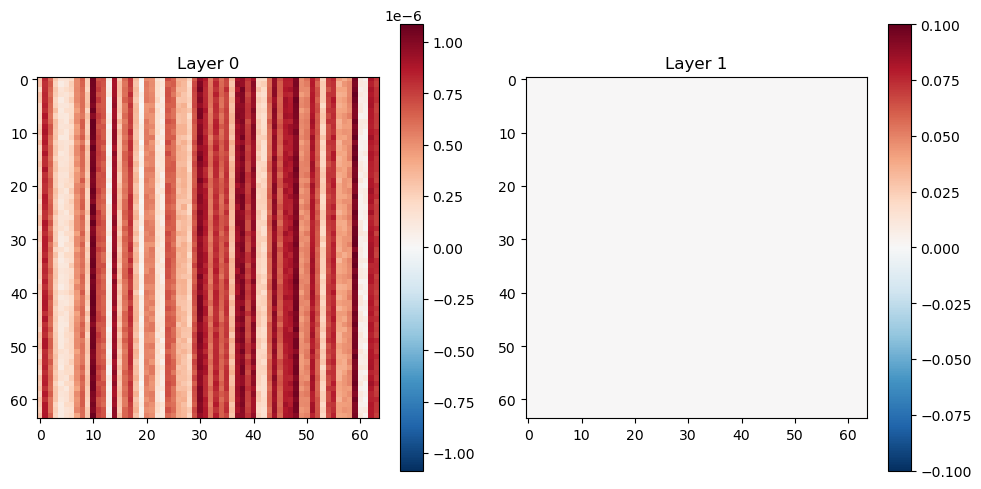

In [30]:
# Reshape the first state back to the q shape
q_shape = q_init.shape
q_first = xs[0].reshape(q_shape)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for layer, ax in enumerate(axs):
    data = q_first[layer]
    vmax = jnp.abs(data).max()
    ax.set_title(f"Layer {layer}")
    im = ax.imshow(data, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [26]:
xs[1]

Array([nan, nan, nan, ..., nan, nan, nan], dtype=float64)